# Model Experiments

In [191]:
%matplotlib inline

from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [220]:
df_fires = pd.read_csv('df_fire_sample.csv')
df_fires.fire_size_class = df_fires.fire_size_class.fillna('')

df_fires_encoded = pd.get_dummies(df_fires.drop(['fire_size_class'], axis=1), columns=['month'])
scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.fire_size_class > ''

num_fires = (y == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie unbalanced)')

X_train_unbal, X_test, y_train_unbal, y_test = train_test_split(X, y, random_state=42)
print(f'X_train_unbal: {len(X_train_unbal)}, X_test: {len(X_test)}, y_train_unbal: {len(y_train_unbal)}, y_test: {len(y_test)}')

print('---- BALANCING ----')

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train_unbal, y_train_unbal)

num_fires = (y_train == True).sum()
num_data_pt = len(y_train)
print(f'Train data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie balanced)')
num_fires = (y_test == True).sum()
num_data_pt = len(y_test)
print(f'Test data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie unbalanced)')
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


16597 fires out of 116597 data points
No fires 86.0% of the time (ie unbalanced)
X_train_unbal: 87447, X_test: 29150, y_train_unbal: 87447, y_test: 29150
---- BALANCING ----
Train data: no fires 50.0% of the time (ie balanced)
Test data: no fires 86.0% of the time (ie unbalanced)
X_train: 149898, X_test: 29150, y_train: 149898, y_test: 29150


### All Fire Sizes (A-G)

##### LogisticRegression

In [206]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_test)

print('--------- Log Regression Classification ---------')
print(classification_report(y_test, y_pred_log_reg))

All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.97      0.89      0.93     25051
        True       0.55      0.84      0.67      4099

    accuracy                           0.88     29150
   macro avg       0.76      0.86      0.80     29150
weighted avg       0.91      0.88      0.89     29150



In [207]:
from sklearn.ensemble import RandomForestClassifier

# params = {
#     'n_estimators': np.arange(40, 100, 20),
#     'max_features': np.arange(4, 12, 1),
#     'max_depth': np.arange(10, 20, 2),
#     'min_samples_split': np.arange(4, 12, 2),
#     'min_samples_leaf': np.arange(2, 10, 2),
#     'max_leaf_nodes': np.arange(4, 10, 2),
# }
# For performance hardcode the latest best guess
params = {'n_estimators': [40], 'min_samples_split': [4], 'min_samples_leaf': [2],
          'max_leaf_nodes': [8], 'max_features': [10], 'max_depth': [18]}

rand_forest = GridSearchCV(RandomForestClassifier(), params, scoring="recall")

rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'max_depth': 18, 'max_features': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.97      0.88      0.92     25051
        True       0.54      0.84      0.66      4099

    accuracy                           0.88     29150
   macro avg       0.76      0.86      0.79     29150
weighted avg       0.91      0.88      0.89     29150



Text(0.5, 1.0, 'Random Forest feature importances')

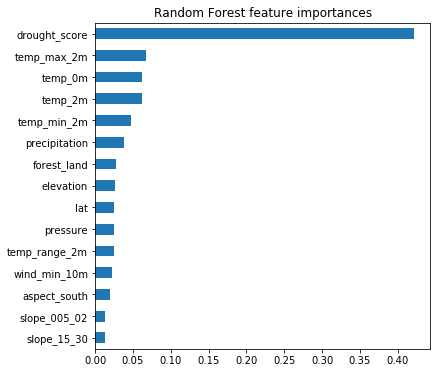

In [208]:
importances_rand_forest = rand_forest.best_estimator_.feature_importances_
importances_rand_forest = pd.Series(importances_rand_forest, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_rand_forest.plot.barh(ax=ax)
ax.set_title('Random Forest feature importances')

In [211]:
import xgboost

# params={
#   'objective': ['binary:logistic'],
#   'max_depth': [3, 6, 9],
#   'gamma':[0, 0.1, 0.5],
#   'learning_rate': [0.1, 0.2, 0.3],
#   'n_estimators': [200],
#   'eval_metric': ['logloss']
# }
# For performance hardcode the latest best guess
params={
  'objective': ['binary:logistic'],
  'max_depth': [6],
  'gamma':[0.1],
  'learning_rate': [0.3],
  'n_estimators': [200],
  'eval_metric': ['logloss']
}

xgb = xgboost.XGBClassifier(seed=42, use_label_encoder=False)

xgb = RandomizedSearchCV(xgb, params, scoring="recall")

xgb.fit(X_train, y_train)

print("Best Params:", xgb.best_params_)

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'eval_metric': 'logloss'}


In [212]:
y_pred_xgb = xgb.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.99      0.98      0.99     25051
        True       0.90      0.96      0.93      4099

    accuracy                           0.98     29150
   macro avg       0.95      0.97      0.96     29150
weighted avg       0.98      0.98      0.98     29150



Text(0.5, 1.0, 'XGBoost feature importances')

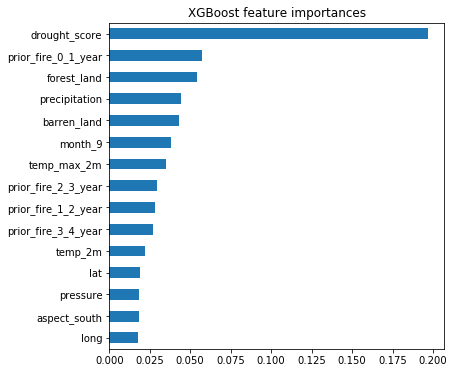

In [213]:
importances_xgb = xgb.best_estimator_.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


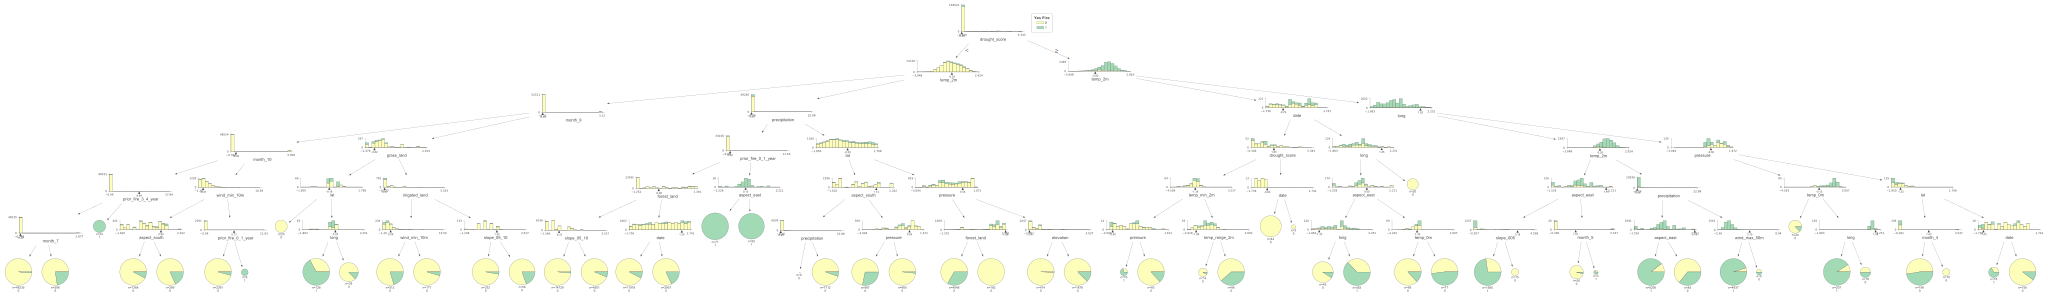

In [214]:
from dtreeviz import trees 

feat_cols = df_fires_encoded.columns.to_list()
trees.dtreeviz(xgb.best_estimator_, X, y, feat_cols, 'Yes Fire', class_names=[0, 1], tree_index=1)

In [209]:
import lightgbm as lgbm

gbm = lgbm.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.4],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

# For performance use the best params
# params = {'objective': ['binary'], 'num_leaves': [5000], 'min_data_in_leaf': [800], 'metric': ['binary_logloss'], 'max_depth': [6],
#           'max_bin': [200], 'learning_rate': [0.8], 'feature_fraction': [0.2], 'bagging_freq': [1], 'bagging_fraction': [0.7]}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.8000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000000000000003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.8000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000000000000003
[LightGBM] [Warning] bagging_freq is s

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.2, 0.4],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                                        'objective': ['binary']},
                   scoring='recall')

In [210]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

# print('--------- LightGBM Report for Original Training Data ---------')
# y_train_pred_gbm = gbm.predict(X_train)
# print(classification_report(y_train, y_train_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 500, 'min_data_in_leaf': 600, 'metric': 'binary_logloss', 'max_depth': 10, 'max_bin': 300, 'learning_rate': 0.2, 'feature_fraction': 0.4000000000000001, 'bagging_freq': 1, 'bagging_fraction': 0.8000000000000003}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.99      0.98      0.98     25051
        True       0.86      0.96      0.91      4099

    accuracy                           0.97     29150
   macro avg       0.93      0.97      0.95     29150
weighted avg       0.98      0.97      0.97     29150



Text(0.5, 1.0, 'LGBM feature importances')

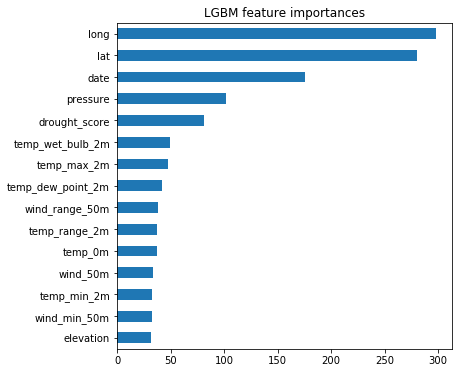

In [ ]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')

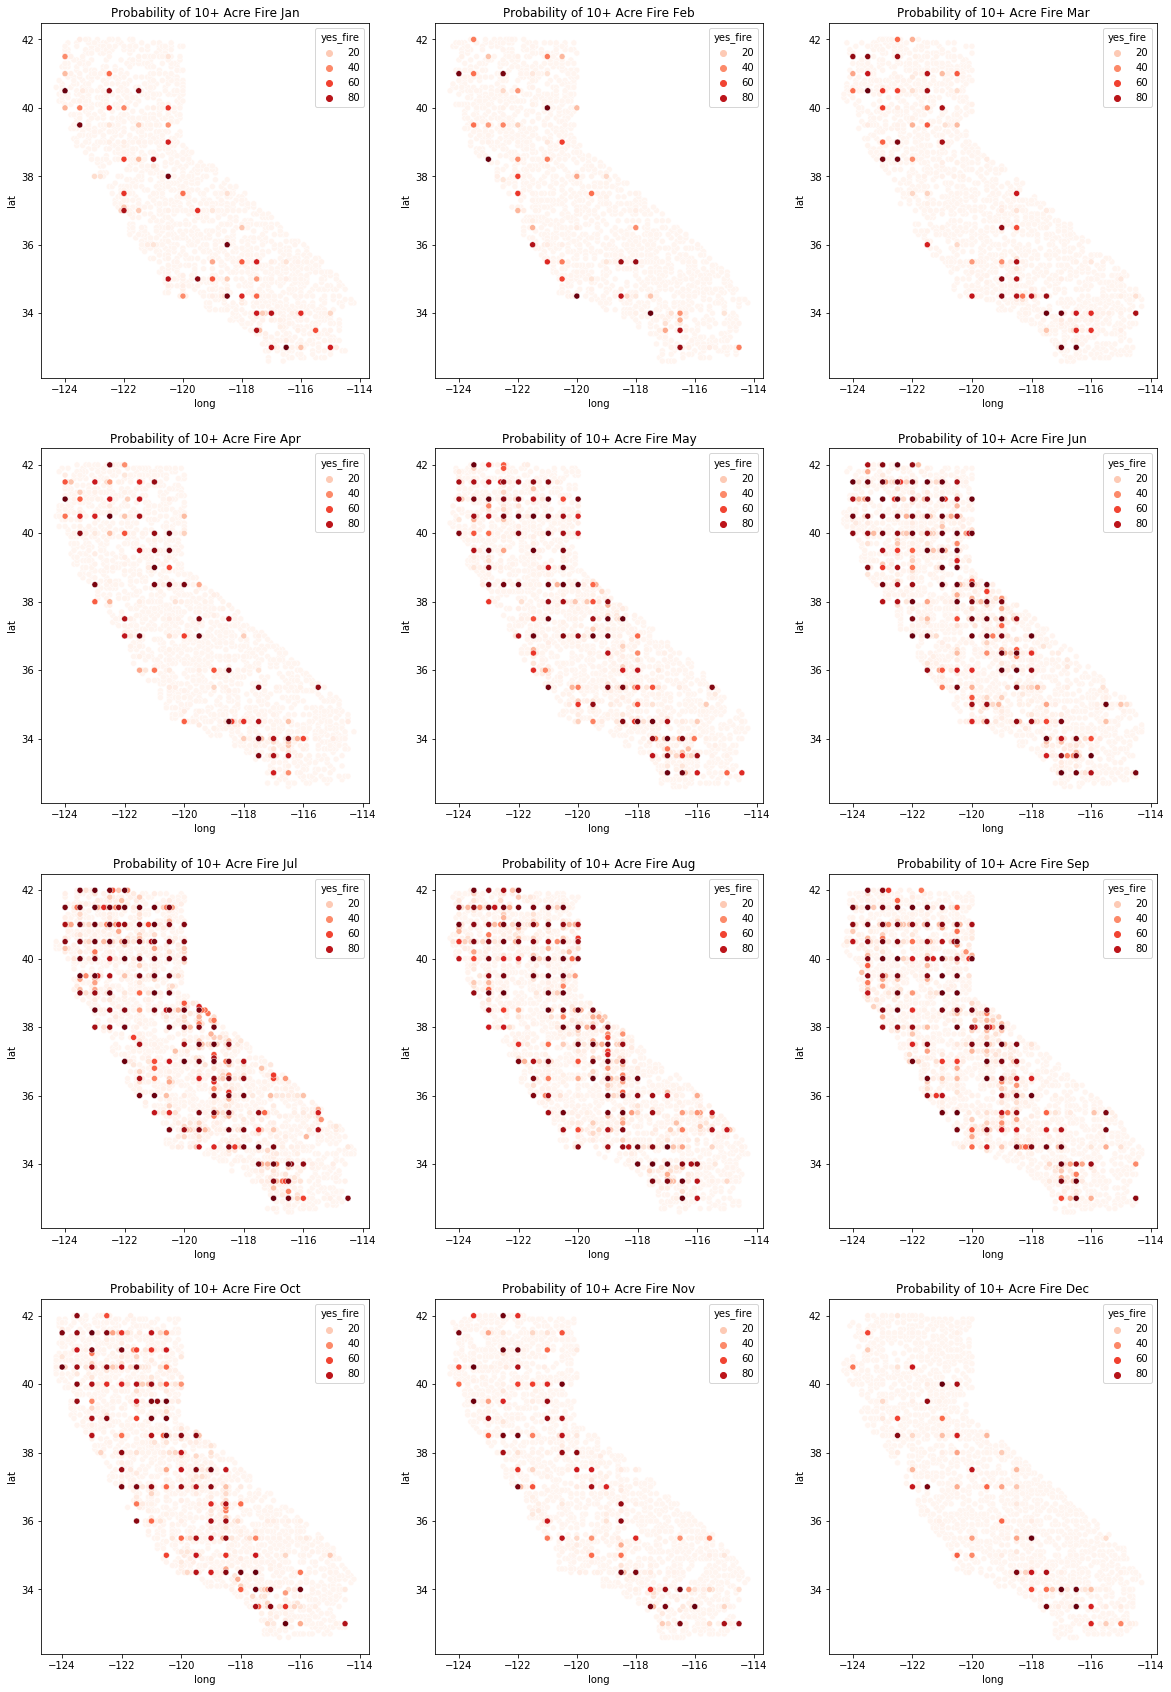

In [215]:
import datetime

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(df_fires, df_fires.fire_size_class > '', random_state=42)
X_orig_test = X_orig_test.reset_index(drop=True)
proba_xgb = pd.DataFrame(xgb.predict_proba(X_test), columns=['no_fire', 'yes_fire'])
proba_xgb = pd.concat([X_orig_test, proba_xgb], axis=1)
proba_xgb['yes_fire'] = proba_xgb.yes_fire * 100
proba_xgb = proba_xgb.drop(columns=proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
proba_month = proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index().sort_values('yes_fire')

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of 10+ Acre Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=proba_month[proba_month.month == i], palette='Reds', hue='yes_fire')

### Only Larger Fire Sizes (10-5000+ arces)

A=0-0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres

In [226]:
y_large = df_fires.fire_size_class >= 'C'

X_large_train_unbal, X_large_test, y_large_train_unbal, y_large_test = train_test_split(X, y_large, random_state=42)

smote = SMOTE()
X_large_train, y_large_train = smote.fit_resample(X_large_train_unbal, y_large_train_unbal)

num_fires = (y_large_train == True).sum()
num_data_pt = len(y_large_train)
print(f'Train data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie balanced)')
num_fires = (y_large_test == True).sum()
num_data_pt = len(y_large_test)
print(f'Test data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie unbalanced)')
print(f'X_train: {len(X_large_train)}, X_test: {len(X_large_test)}, y_train: {len(y_large_train)}, y_test: {len(y_large_test)}')

Train data: no fires 50.0% of the time (ie balanced)
Test data: no fires 99.0% of the time (ie unbalanced)
X_train: 172190, X_test: 29150, y_train: 172190, y_test: 29150


In [227]:
params={
  'C': [0.1],
}

log_reg_large = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg_large = GridSearchCV(estimator=log_reg_large, param_grid=params, scoring='recall', cv=5)

log_reg_large.fit(X_large_train, y_large_train)

print(f'10+ acre fires estimator', log_reg_large.best_estimator_)

y_large_pred_log_reg = log_reg_large.predict(X_large_test)

print('--------- Log Regression Classification (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_log_reg))

10+ acre fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       1.00      0.80      0.89     28718
        True       0.06      0.84      0.11       432

    accuracy                           0.80     29150
   macro avg       0.53      0.82      0.50     29150
weighted avg       0.98      0.80      0.88     29150



In [228]:
import xgboost

# params = {
#     'objective': ['binary:logistic'],
#     'max_depth': [3, 6, 9],
#     'gamma': [0, 0.1, 0.4],
#     # 'subsample': [0.5],
#     # 'colsample_bytree': [0.1],
#     # 'colsample_bylevel': [1.0],
#     'learning_rate': [0.1, 0.2],
#     'n_estimators': [200],
#     'eval_metric': ['logloss']
# }
params = {'eval_metric': ['logloss'], 'gamma': [0], 'learning_rate': [0.1],
          'max_depth': [9], 'n_estimators': [200], 'objective': ['binary:logistic']}

xgb_large = xgboost.XGBClassifier(seed=42, use_label_encoder=False)
xgb_large = GridSearchCV(estimator=xgb_large, scoring="recall", param_grid=params)

xgb_large.fit(X_large_train, y_large_train)

print("10+ acre best Params:", xgb_large.best_params_)

y_large_pred_xgb = xgb_large.predict(X_large_test)

print('--------- XGBoost Classification Report (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_xgb))

10+ acre best Params: {'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic'}
--------- XGBoost Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     28718
        True       0.45      0.61      0.52       432

    accuracy                           0.98     29150
   macro avg       0.72      0.80      0.75     29150
weighted avg       0.99      0.98      0.98     29150



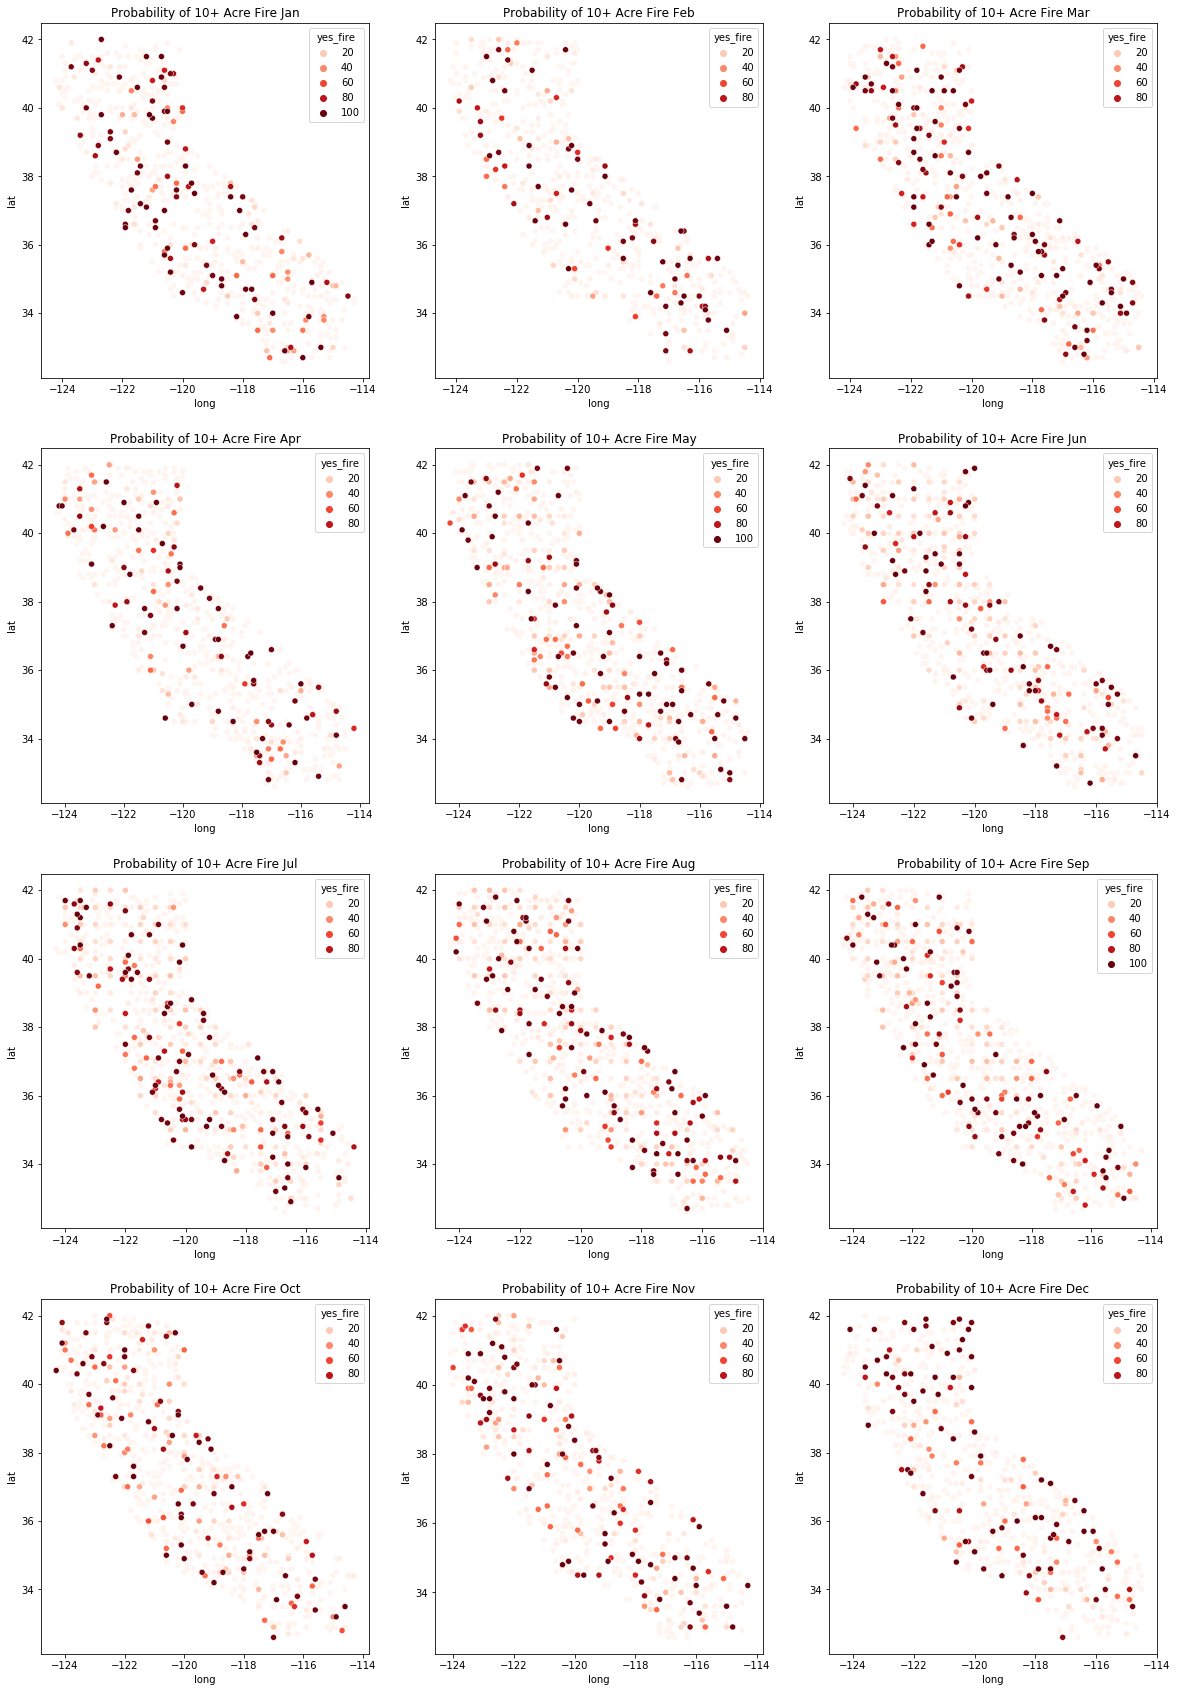

In [229]:
import datetime

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(df_fires_large, df_fires_large.fire_size_class > 'C', random_state=42)
X_orig_test = X_orig_test.reset_index(drop=True)
proba_xgb = pd.DataFrame(xgb.predict_proba(X_large_test), columns=['no_fire', 'yes_fire'])
proba_xgb = pd.concat([X_orig_test, proba_xgb], axis=1)
proba_xgb['yes_fire'] = proba_xgb.yes_fire * 100
proba_xgb = proba_xgb.drop(columns=proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
proba_month = proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index().sort_values('yes_fire')

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of 10+ Acre Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=proba_month[proba_month.month == i], palette='Reds', hue='yes_fire')

In [230]:
import lightgbm as lgb

gbm_large = lgb.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.5, 0.8, 1.2],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

gbm_large = RandomizedSearchCV(estimator=gbm_large, param_distributions=params, scoring="recall", cv=3)
gbm_large.fit(X_large_train, y_large_train)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] feature_fraction is set=0.8000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000000000000003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] feature_fraction is set=0.8000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000000000000003
[LightGBM] [Warning] bagging_freq is set=1

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.2, 0.5, 0.8,
                                                          1.2],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                                  

In [231]:
print(f'Best params: {gbm_large.best_params_}')

y_large_pred_gbm = gbm.predict(X_large_test)

print('--------- LightGBM Classification Report (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 500, 'min_data_in_leaf': 400, 'metric': 'binary_logloss', 'max_depth': 10, 'max_bin': 300, 'learning_rate': 0.8, 'feature_fraction': 0.8000000000000003, 'bagging_freq': 1, 'bagging_fraction': 0.8000000000000003}
--------- LightGBM Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       1.00      0.86      0.92     28718
        True       0.09      0.95      0.17       432

    accuracy                           0.86     29150
   macro avg       0.54      0.90      0.54     29150
weighted avg       0.99      0.86      0.91     29150

